# this notebook **heavily** inspect the data prepared by stage2
# TODO: plot resp. param. vs. resp. param. plots across subjects (gird), 80%
# TODO: plot sig beats for interested activity, 70%
# TODO: implement beats inspection

In [1]:
import numpy as np
from numpy_ext import rolling_apply
import numba as nb

import argparse

import os
import math
from math import sin

import pandas as pd
from sklearn.linear_model import LinearRegression


import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns

i_seed = 0

import sys
sys.path.append('../') # add this line so Data and" data are visible in this file
sys.path.append('../../') # add this line so Data "and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from filters import *
from setting import *
from plotting_tools import *
from stage1_patch import *
from TimeStampReader import *
from stage1_cosmed import *
from PatchParser import *
from preprocessing import *
from ECG_module import *
from PPG_module import *
from segmentation import *
from stage3_inspection import *
from stage4_regression import *


from importlib import reload
%load_ext autoreload
%autoreload 2

In [2]:
import pycwt as wavelet


In [3]:
# df = pd.DataFrame({'A': {0: 'a', 1: 'b', 2: 'c'},
#                    'B': {0: 1, 1: 3, 2: 5},
#                    'C': {0: 2, 1: 4, 2: 6}})

# df

In [15]:
# import cartopy.crs as ccrs


# fig, (ax1, ax2) = plt.subplots(2,4, subplot_kw={'projection': ccrs.PlateCarree()})


In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal # spectrogram function
from matplotlib import cm # colour map
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 

# basic config
sample_rate = 11240.  # 
sig_len_secs = 10
frequency = 2000.

# generate the signal
timestamps_secs = np.arange(sample_rate*sig_len_secs) / sample_rate
mysignal = np.sin(2.0 * np.pi * frequency * timestamps_secs) 

# extract the spectrum
freq_bins, timestamps, spec = signal.spectrogram(mysignal, sample_rate)

# 3d plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(freq_bins[:, None], timestamps[None, :], 10.0*np.log10(spec), cmap=cm.coolwarm)
ax.set_xlabel('freq')
plt.show()


In [17]:
freq_bins.shape, timestamps.shape

((129,), (501,))

In [18]:
freq_bins

array([   0.     ,   43.90625,   87.8125 ,  131.71875,  175.625  ,
        219.53125,  263.4375 ,  307.34375,  351.25   ,  395.15625,
        439.0625 ,  482.96875,  526.875  ,  570.78125,  614.6875 ,
        658.59375,  702.5    ,  746.40625,  790.3125 ,  834.21875,
        878.125  ,  922.03125,  965.9375 , 1009.84375, 1053.75   ,
       1097.65625, 1141.5625 , 1185.46875, 1229.375  , 1273.28125,
       1317.1875 , 1361.09375, 1405.     , 1448.90625, 1492.8125 ,
       1536.71875, 1580.625  , 1624.53125, 1668.4375 , 1712.34375,
       1756.25   , 1800.15625, 1844.0625 , 1887.96875, 1931.875  ,
       1975.78125, 2019.6875 , 2063.59375, 2107.5    , 2151.40625,
       2195.3125 , 2239.21875, 2283.125  , 2327.03125, 2370.9375 ,
       2414.84375, 2458.75   , 2502.65625, 2546.5625 , 2590.46875,
       2634.375  , 2678.28125, 2722.1875 , 2766.09375, 2810.     ,
       2853.90625, 2897.8125 , 2941.71875, 2985.625  , 3029.53125,
       3073.4375 , 3117.34375, 3161.25   , 3205.15625, 3249.06

In [5]:
# pd.melt(df, id_vars=['A'], value_vars=['B', 'C'])


In [6]:
parser = argparse.ArgumentParser(description='SpO2_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')

# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../../data/stage2/', 
                          '--output_folder', '../../data/stage3/win60_overlap90/',
                         ])
# args = parser.parse_args()
print(args)

Namespace(input_folder='../../data/stage2/', output_folder='../../data/stage3/win60_overlap90/')


In [7]:
keep_tasks = ['Baseline 0', 'Standing 0', 
              '6MWT 0', 'Recovery 0',
              '6MWT-R 0', 'Recovery 1', 
              'Stair 0', 'Recovery 2', 
              'Walk 0', 'Recovery 3',
              'Run 0', 'Recovery 4']

In [8]:
inputdir = args.input_folder
outputdir = args.output_folder
# subject_id = args.subject_id

if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
# outputdir_sub = outputdir+subject_id.split('sub')[1]+'/inspection/'
# if not os.path.exists(outputdir):
#     os.makedirs(outputdir)
    

# plot beats (acc, ecg, ppg)

In [9]:
# del df_sync

df_sync = pd.DataFrame()

for i in range(300):
    subject_id = 'sub'+str(i)

    # TODO: "transplant" the ECG of their other patches to the chest
#     if (subject_id!='sub212') and (subject_id!='sub121'):
#         continue
    # if (subject_id!='sub117'):
    # if (subject_id!='sub103'):
    #     continue
    if (subject_id!='sub108'):
        continue
    
    inputdir_sub = inputdir+subject_id+'/'
    if subject_id not in os.listdir(inputdir):
        continue
   
    print('subject_id is ', subject_id)

    for syn_file in os.listdir(inputdir_sub):
        if '.feather'  not in syn_file:
            continue
            
        df_sub = pd.read_feather(inputdir_sub+syn_file)
#             df_sub = filter_DFcolumns(df_sub.copy(), Fs)
        df_sub['subject_id'] = int(subject_id.split('sub')[1])

#             df_sync = df_sync.append(df_sub[['time', 'subject_id', 'task', 'ECG', 'accelX', 'accelY','accelZ', 'ppg_g_1', 'ppg_r_1', 'ppg_ir_1', 'ppg_g_2', 'ppg_r_2','ppg_ir_2']])
    
    
    
        # get raw task names except for Transition
        task_unique = df_sub['task'].unique()
        
        task_unique = task_unique[task_unique!='Transition']

#         sys.exit()
    #     print(task_unique)
    

        for task_name in keep_tasks:
            if 'Recovery' in task_name:
                previous_task = task_unique[np.where(task_unique==task_name)[0]-1][0]
                task_name_new = previous_task.split(' ')[0] + ' Recovery'
            else:
                task_name_new = task_name.split(' ')[0]


            df_task = df_sub[df_sub['task']==task_name].copy()

            df_task['task'] = task_name_new
        
        
        
        
        
    

#         for task_name in keep_tasks:
#             if 'Recovery' in task_name:
#                 previous_task = task_unique[np.where(task_unique==task_name)[0]-1][0]
#                 task_name_new = previous_task.split(' ')[0] + ' Recovery'
#             else:
#                 task_name_new = task_name.split(' ')[0]

                
#         sys.exit()
#         df_sub['task'] = task_name_new
                
            df_sync = df_sync.append(df_task)
print('done!')

subject_id is  sub108
done!


In [10]:
# df_sync

In [11]:
df_sub['task'].unique()

array(['Transition', 'Baseline 0', 'Standing 0', 'Proning 0', 'LL 0',
       'LR 0', 'Cough 0', 'SpeakCasual 0', 'SpeakScripted 0', '6MWT 0',
       'Recovery 0', '6MWT-R 0', 'Recovery 1', 'StairDown0', 'StairUp0',
       'StairDown1', 'Recovery 2', 'Cough 1', 'SpeakCasual 1',
       'SpeakScripted 1', 'Walk 0', 'Recovery 3', 'Run 0', 'Recovery 4'],
      dtype=object)

In [12]:
beats_id = [1, 10, 2, 6, 11, 3, 7, 4, 8, 12, 0]
use_ensemble = True

N_enBeats = 4
# for task_name in FS_tasks:
# for task_name in ['Baseline', 'Standing', '6MWT', '6MWT Recovery', '6MWT-R', '6MWT-R Recovery', 'Stair', 'Stair Recovery', 'Walk', 'Walk Recovery', 'Run', 'Run Recovery']:


for subject_id in df_sync['subject_id'].unique():
    
#     if subject_id!=1-3:
#         continue
    df_sub = df_sync[df_sync['subject_id']==subject_id]
    
    

    #     t_start = df_sync[df_sync['task']==task_name]['time'].min()


#     for task_name in ['Baseline 0', 'Standing 0', 'Recovery 0', 'Recovery 1', 'Recovery 2', 'Recovery 3', 'Recovery 4']:
    for task_name in ['Baseline', 'Standing', '6MWT Recovery', '6MWT-R Recovery',  'Stair Recovery', 'Walk Recovery', 'Run Recovery', '6MWT', '6MWT-R', 'Stair', 'Walk', 'Run']:

        # if task_name!='Baseline':
        #     continue
        if task_name!='6MWT':
            continue
#         if task_name!='Walk Recovery':
#             continue

        if task_name not in df_sub['task'].unique():
            print('task_name not in df_sync')
            continue
        print('[{}] working on {}...'.format(subject_id, task_name))
        
        # 0. select a specific task
        t_start = df_sub[df_sub['task']==task_name]['time'].min()
        t_end = df_sub[df_sub['task']==task_name]['time'].max()
        
        df = df_sub.copy()
        df = df[(df['time'] >= t_start) & (df['time'] <= t_end)]

        # 1. plot signals for each activity
        plot_all_sync(df, subject_id, fig_name=task_name, outputdir=outputdir+str(subject_id)+'/inspection/all_sync/', show_plot=False)

        # 2. detect QRS complex
        hr = df['HR_cosmed'].values
        ECG = df['ECG'].values
        Fs = FS_RESAMPLE
        # my ECG master function (extract R peaks, S peaks, PT peaks, etc.)
        QRS_detector_dict = task_HR_detector(ECG, Fs, fig_name=None, outputdir=None, show_plot=True)

        print('\trejection ratio: {:.2f}'.format(1-QRS_detector_dict['N_kept']/QRS_detector_dict['N_detected']))

        start_offset = -200
        end_offset = 200

        beats_dict = segment_df(get_filt_df(df, Fs).copy(), QRS_detector_dict, Fs,  start_offset=start_offset, end_offset=end_offset)
        # beats_dict = segment_df(get_filt_df(df, Fs).copy(), QRS_detector_dict, Fs,  start_offset=None, end_offset=None)

        if use_ensemble:
            for key in beats_dict:
                if 'ppg' in key:
                    sig_beats = beats_dict[key]
                    beats_dict[key] = get_ensemble_beats(sig_beats, N_enBeats=N_enBeats, use_woody=False)
                elif 'scg' in key:
                    sig_beats = beats_dict[key]
                    beats_dict[key] = get_ensemble_beats(sig_beats, N_enBeats=N_enBeats, use_woody=False)


        plot_ALL_beats(beats_dict, beats_id, subject_id, Fs, show_good=True, fig_name=task_name+'en{}'.format(N_enBeats), outputdir=outputdir+str(subject_id)+'/inspection/good_beats/', show_plot=False)


#         if task_name == '6MWT':
#             sys.exit()
        # if task_name == 'baseline':
        sys.exit()
#         if task_name == 'Walk Recovery':
#             sys.exit()

        # 3. check QRS detector
        inspect_QRS_detector(QRS_detector_dict, subject_id, Fs, fig_name=task_name, outputdir=outputdir+str(subject_id)+'/inspection/RS_peaks/', show_plot=False)


[108] working on 6MWT...
	 use S peaks
	 use S peaks
	rejection ratio: -0.09


SystemExit: 

/home/mchan/miniconda3/envs/mienv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [156]:
# segment_d f

In [157]:
# fig, axes = plt.subplots(2,1, figsize=(5,10))
# axes[0].plot(SCG_lat_beats[:,0])
# axes[0].plot(np.abs(hilbert(SCG_lat_beats, axis=0))[:,0])


# # axes[0].plot(get_smooth(SCG_lat_beats[:,0]**2, N=20)**0.5)

In [158]:
# get_padded_filt

In [15]:
acc_x = df['accelX'].values
acc_y = df['accelY'].values
acc_z = df['accelZ'].values

scg_x = get_padded_filt(acc_x, filter_padded=1, lowcutoff=FILT_SCG[0], highcutoff=FILT_SCG[1], Fs=FS_RESAMPLE)
scg_y = get_padded_filt(acc_y, filter_padded=1, lowcutoff=FILT_SCG[0], highcutoff=FILT_SCG[1], Fs=FS_RESAMPLE)
scg_z = get_padded_filt(acc_z, filter_padded=1, lowcutoff=FILT_SCG[0], highcutoff=FILT_SCG[1], Fs=FS_RESAMPLE)
ECG = get_padded_filt(df['ECG'].values, lowcutoff=FILT_ECG[0], highcutoff=FILT_ECG[1], Fs=FS_RESAMPLE)

# scg_x = df['accelX'].values
# scg_y = df['accelY'].values
# scg_z = df['accelZ'].values

In [ ]:
t_sig = np.arange(scg_x.shape[0])/FS_RESAMPLE

fig, axes = plt.subplots(3,1,figsize=(40,5))
ax = axes[0]
ax.plot(t_sig, acc_x, alpha=0.7, color=color_dict[sync_color_dict['scg_x']])
ax.plot(t_sig, acc_y, alpha=0.7, color=color_dict[sync_color_dict['scg_y']])
ax.plot(t_sig, acc_z, alpha=0.7, color=color_dict[sync_color_dict['scg_z']])
ax = axes[1]
ax.plot(t_sig, scg_x, alpha=0.7, color=color_dict[sync_color_dict['scg_x']])
ax.plot(t_sig, scg_y, alpha=0.7, color=color_dict[sync_color_dict['scg_y']])
ax.plot(t_sig, scg_z, alpha=0.7, color=color_dict[sync_color_dict['scg_z']])

ax = axes[2]
ax.plot(t_sig, ECG, alpha=0.7, color=color_dict[sync_color_dict['ECG']])
for ax in axes:
    ax.set_xlim(30,50)

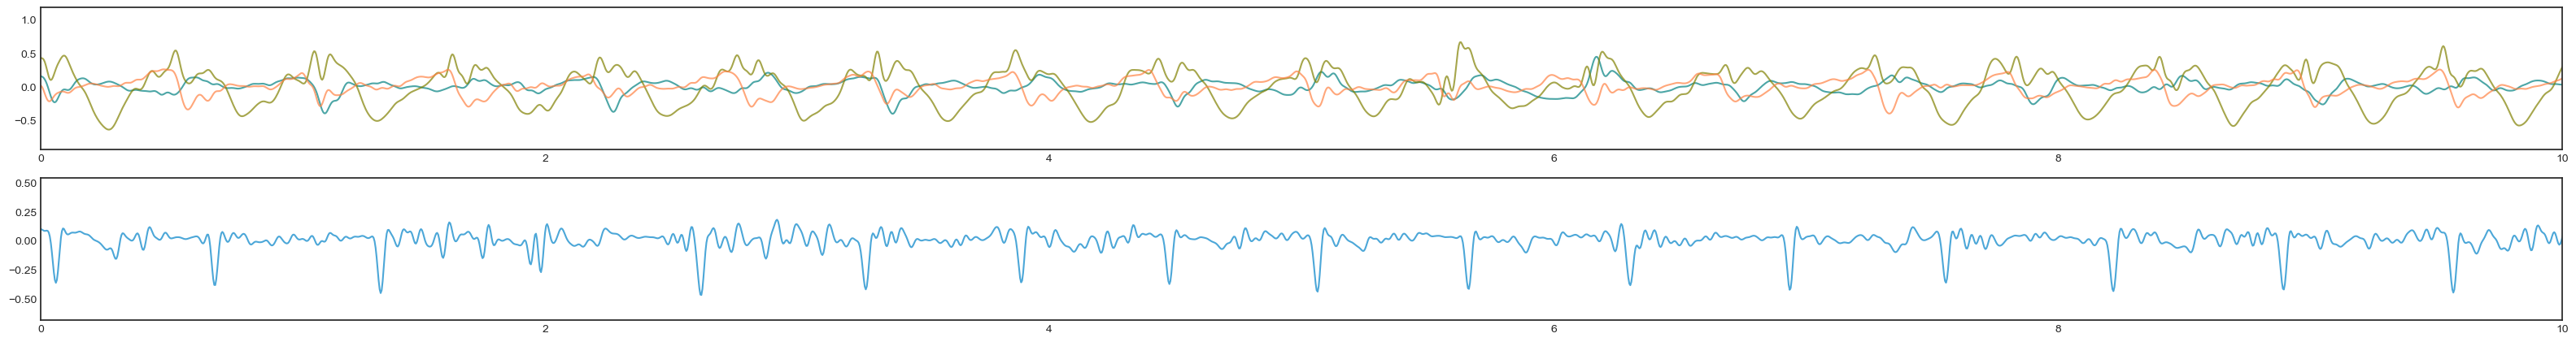

In [14]:
t_sig = np.arange(scg_x.shape[0])/FS_RESAMPLE

fig, axes = plt.subplots(2,1,figsize=(40,5))
ax = axes[0]
ax.plot(t_sig, scg_x, alpha=0.7, color=color_dict[sync_color_dict['scg_z']])
ax.plot(t_sig, scg_y, alpha=0.7, color=color_dict[sync_color_dict['scg_y']])
ax.plot(t_sig, scg_z, alpha=0.7, color=color_dict[sync_color_dict['scg_x']])

ax = axes[1]
ax.plot(t_sig, ECG, alpha=0.7, color=color_dict[sync_color_dict['ECG']])
for ax in axes:
    ax.set_xlim(0,10)

In [161]:
# beat_start = -int(0.1*FS_RESAMPLE)

beat_end = int(0.2*FS_RESAMPLE)

SCG_lat_beats = beats_dict['scg_x'][:beat_end,:]
SCG_hf_beats = beats_dict['scg_y'][:beat_end,:]
SCG_dv_beats = beats_dict['scg_z'][:beat_end,:]
ecg_beats = beats_dict['ecg_beats'][:beat_end,:]


SCG_lat_beats_hb = np.abs(hilbert(SCG_lat_beats, axis=0))
SCG_hf_beats_hb = np.abs(hilbert(SCG_hf_beats, axis=0))
SCG_dv_beats_hb = np.abs(hilbert(SCG_dv_beats, axis=0))


def plot_beats_smooth(ecg_beats, SCG_lat_beats, SCG_hf_beats, SCG_dv_beats, Fs):

    t_scg = np.arange(SCG_dv_beats.T.flatten().shape[0])/FS_RESAMPLE

    fig, ax = plt.subplots(1,1,figsize=(40,2))
    ax.plot(t_scg, SCG_dv_beats.T.flatten(), alpha=0.7, color=color_dict[sync_color_dict['scg_z']])
    ax.plot(t_scg, SCG_hf_beats.T.flatten(), alpha=0.7, color=color_dict[sync_color_dict['scg_y']])
    ax.plot(t_scg, SCG_lat_beats.T.flatten(), alpha=0.7, color=color_dict[sync_color_dict['scg_x']])
    ax.set_xlim(0,5)

    fig, axes = plt.subplots(1,4,figsize=(20,5))
    t_beat = np.arange(SCG_dv_beats.shape[0])/FS_RESAMPLE

    axes[0].plot(t_beat, ecg_beats, alpha=0.05, color=color_dict[sync_color_dict['ECG']])
    axes[0].set_title('ECG')

    axes[1].plot(t_beat, SCG_lat_beats, alpha=0.05, color=color_dict[sync_color_dict['scg_x']])
    axes[1].set_title('SCG_lat')
    axes[2].plot(t_beat, SCG_hf_beats, alpha=0.05, color=color_dict[sync_color_dict['scg_y']])
    axes[2].set_title('SCG_hf')
    axes[3].plot(t_beat, SCG_dv_beats, alpha=0.05, color=color_dict[sync_color_dict['scg_z']])
    axes[3].set_title('SCG_dv')

    fig, ax = plt.subplots(1,1,figsize=(5,5))
    i = 20
    ax.scatter(SCG_hf_beats.max(axis=0), SCG_dv_beats.max(axis=0), alpha=0.2, color='gray')
    ax.set_xlabel('HF (g)')
    ax.set_ylabel('DV (g)')

# data_lim = 0.05
# ax.set_xlim(-data_lim, data_lim)
# ax.set_ylim(-data_lim, data_lim)

plt.show()

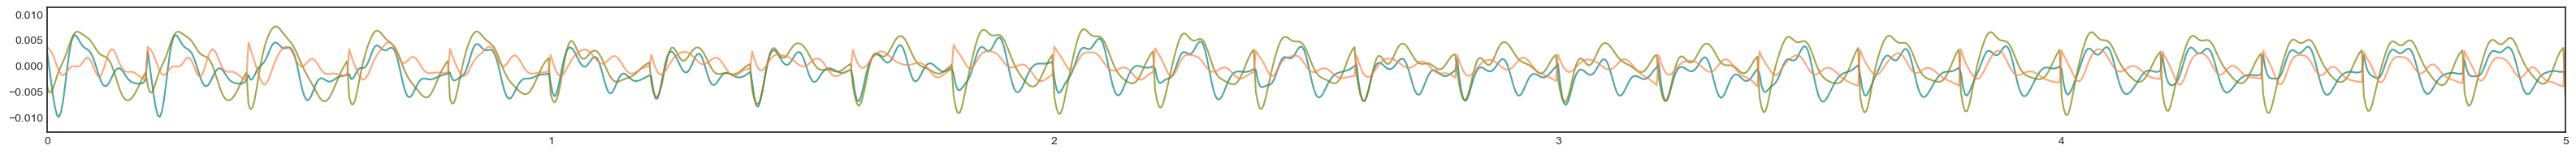

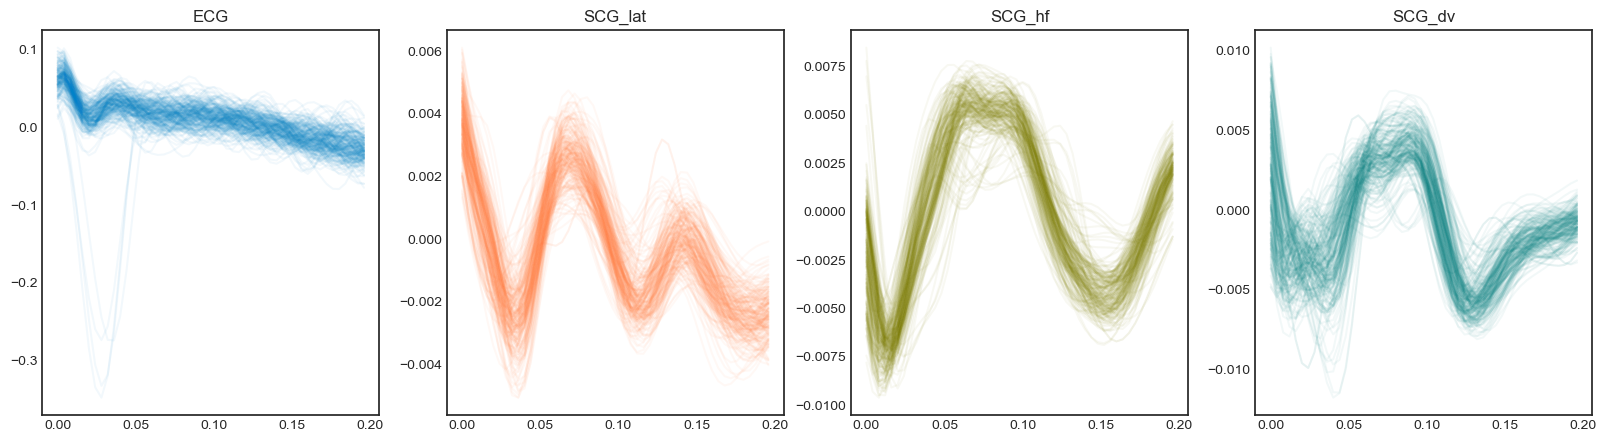

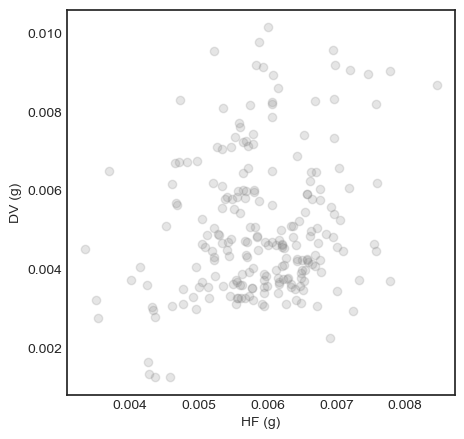

In [162]:
plot_beats_smooth(ecg_beats, SCG_lat_beats, SCG_hf_beats, SCG_dv_beats, FS_RESAMPLE)


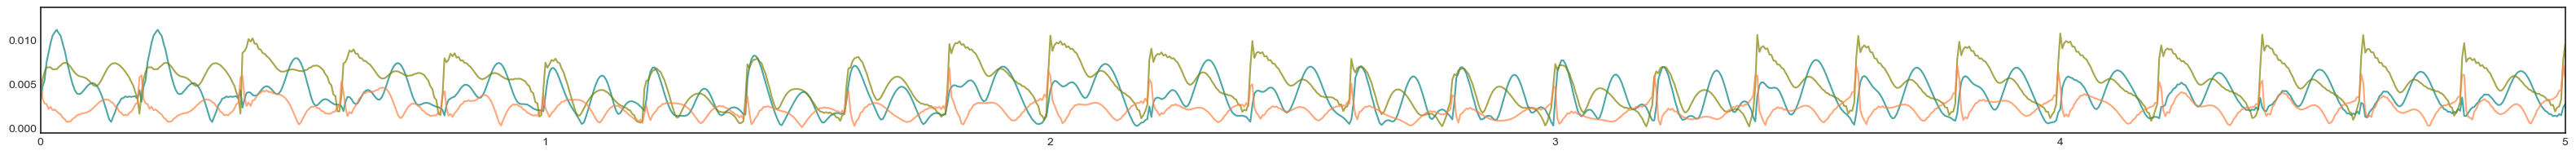

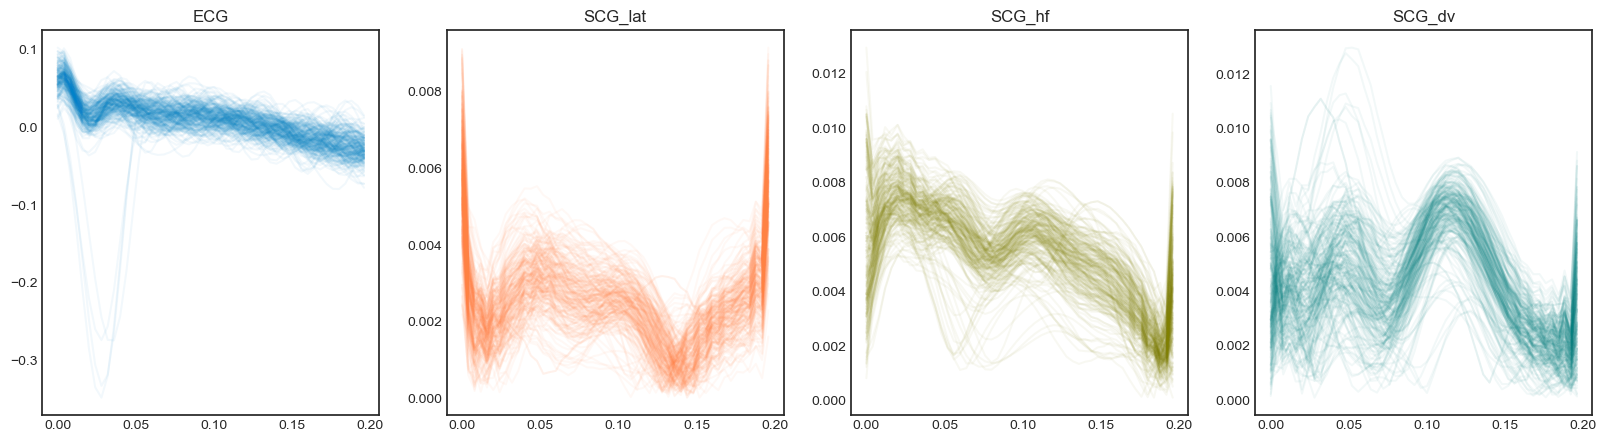

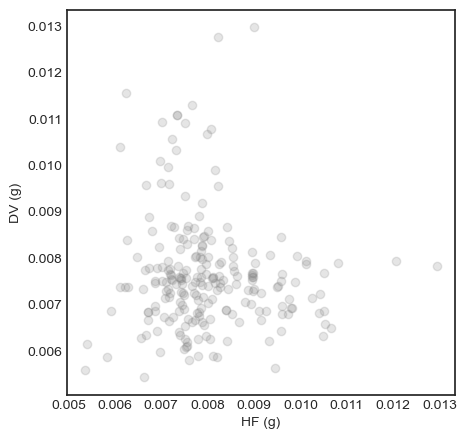

In [163]:
plot_beats_smooth(ecg_beats, SCG_lat_beats_hb, SCG_hf_beats_hb, SCG_dv_beats_hb, FS_RESAMPLE)


In [164]:
SCG_lat_beats_hb.shape

(50, 221)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


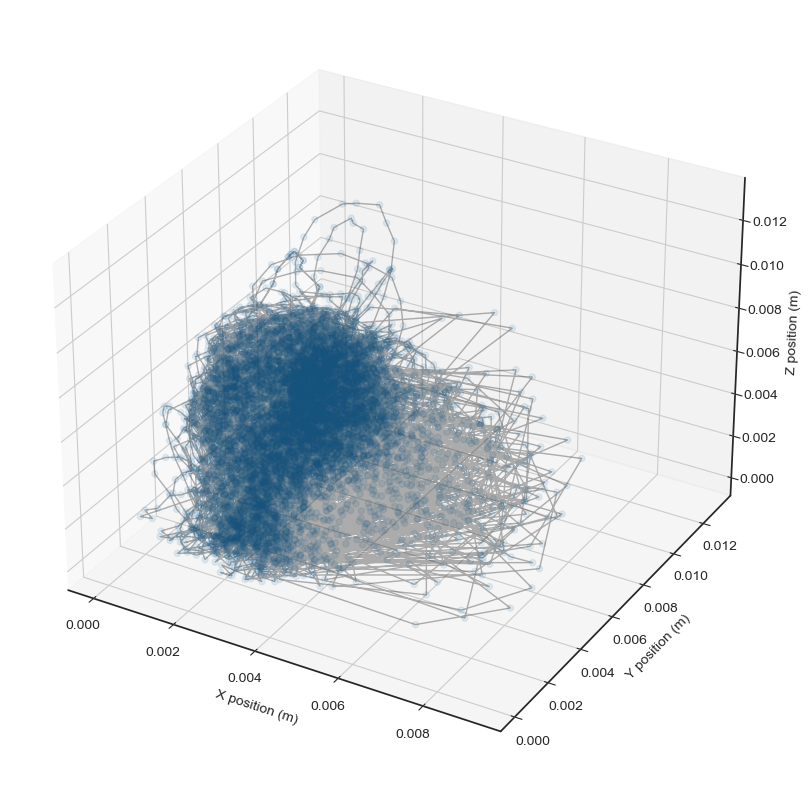

In [165]:
import matplotlib as mpl

# ax = plt.axes(projection='3d', )
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(10,10))

col = np.arange(SCG_lat_beats_hb.T.flatten().shape[0])

ax.plot3D(SCG_lat_beats_hb.T.flatten(), SCG_hf_beats_hb.T.flatten(), SCG_dv_beats_hb.T.flatten(),lw=1, alpha=0.3, color='black')
ax.scatter3D(SCG_lat_beats_hb.T.flatten(), SCG_hf_beats_hb.T.flatten(), SCG_dv_beats_hb.T.flatten(), alpha=0.1, cmap=mpl.colormaps['cividis'])

ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
ax.legend(fontsize='x-large')
plt.show()

# 6MWT

In [ ]:
# df_copy = get_filt_df(df, Fs).copy()
SCG_lat = df['accelX'].values
SCG_hf = df['accelY'].values
SCG_dv = df['accelZ'].values

t_scg = np.arange(SCG_dv.shape[0])/FS_RESAMPLE

fig, ax = plt.subplots(1,1,figsize=(20,2))
# plt.figure(figsize=(20,2)) 
ax.plot(t_scg, SCG_lat, alpha=0.7)
ax.plot(t_scg, SCG_hf, alpha=0.7)
ax.plot(t_scg, SCG_dv, alpha=0.7)
ax.set_xlim(0,50)


# fig, ax = plt.subplots(1,1,figsize=(5,5))
# fig = plt.figure(figsize=(5,5))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(SCG_lat, SCG_hf, SCG_dv, alpha=0.005)

fig, ax = plt.subplots(1,1,figsize=(5,5))
# ax.scatter(SCG_lat, SCG_dv, alpha=0.002)
ax.scatter(SCG_hf, SCG_dv, alpha=0.02)
# ax.set_xlim(-0.02,0.02)
# ax.set_ylim(-0.02,0.02)

plt.show()

In [ ]:
df_copy = get_filt_df(df, Fs).copy()
SCG_lat = df_copy['accelX'].values
SCG_hf = df_copy['accelY'].values
SCG_dv = df_copy['accelZ'].values

# SCG_lat = get_padded_filt(SCG_lat, filter_padded=1, lowcutoff=5, highcutoff=25, Fs=FS_RESAMPLE)
# SCG_hf = get_padded_filt(SCG_hf, filter_padded=1, lowcutoff=5, highcutoff=25, Fs=FS_RESAMPLE)
# SCG_dv = get_padded_filt(SCG_dv, filter_padded=1, lowcutoff=5, highcutoff=25, Fs=FS_RESAMPLE)

t_scg = np.arange(SCG_dv.shape[0])/FS_RESAMPLE

fig, ax = plt.subplots(1,1,figsize=(20,2))
# plt.figure(figsize=(20,2)) 
ax.plot(t_scg, SCG_lat, alpha=0.7)
ax.plot(t_scg, SCG_hf, alpha=0.7)
ax.plot(t_scg, SCG_dv, alpha=0.7)
ax.set_xlim(0,10)



# fig = plt.figure(figsize=(5,5))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(SCG_lat, SCG_hf, SCG_dv, alpha=0.005)

fig, ax = plt.subplots(1,1,figsize=(5,5))
# ax.scatter(SCG_lat, SCG_dv, alpha=0.002)
ax.scatter(SCG_hf, SCG_dv, alpha=0.002)
# ax.scatter(SCG_hf, SCG_lat, alpha=0.002)
# ax.set_xlim(-2,2)
# ax.set_ylim(-2,2)

plt.show()

In [ ]:
df_copy = get_filt_df(df, Fs).copy()
SCG_lat = df_copy['accelX'].values
SCG_hf = df_copy['accelY'].values
SCG_dv = df_copy['accelZ'].values
ecg_sig = df_copy['ECG'].values

SCG_lat = get_padded_filt(SCG_lat, filter_padded=1, lowcutoff=5, highcutoff=25, Fs=FS_RESAMPLE)
SCG_hf = get_padded_filt(SCG_hf, filter_padded=1, lowcutoff=5, highcutoff=25, Fs=FS_RESAMPLE)
SCG_dv = get_padded_filt(SCG_dv, filter_padded=1, lowcutoff=5, highcutoff=25, Fs=FS_RESAMPLE)


t_scg = np.arange(SCG_dv.shape[0])/FS_RESAMPLE

fig, ax = plt.subplots(1,1,figsize=(20,4))
# plt.figure(figsize=(20,2)) 
ax.plot(t_scg, SCG_lat, alpha=0.7)
ax.plot(t_scg, SCG_hf, alpha=0.7)
ax.plot(t_scg, SCG_dv, alpha=0.7)
ax.plot(t_scg, ecg_sig+1, alpha=0.7)
ax.set_xlim(0,10)



# fig = plt.figure(figsize=(5,5))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(SCG_lat, SCG_hf, SCG_dv, alpha=0.005)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(SCG_lat, SCG_dv, alpha=0.002)
# ax.scatter(SCG_hf, SCG_dv, alpha=0.002)
# ax.scatter(ecg_sig, SCG_dv, alpha=0.002)
# ax.set_xlim(-2,2)
# ax.set_ylim(-2,2)

ax.set_xlabel('g')
ax.set_ylabel('g')

plt.show()

In [ ]:
# line

In [ ]:
SCG_lat_beats = beats_dict['scg_x'][:100,:]
SCG_hf_beats = beats_dict['scg_y'][:100,:]
SCG_dv_beats = beats_dict['scg_z'][:100,:]

In [ ]:
from matplotlib import animation, rc

from IPython.display import HTML

fig, ax = plt.subplots()

# ax.set_xlim(( 0, 2))
# ax.set_ylim((-2, 2))
# ax.set_xlim(-1,1)
# ax.set_ylim(-1,1)
# ax.set_xlim(-0.02,0.02)
# ax.set_ylim(-0.02,0.02)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

line, = ax.plot([], [], marker="o",linestyle='None', markersize=5,markeredgecolor="none", markerfacecolor="steelblue", alpha=0.5)


# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
# animation function. This is called sequentially
def animate(i):
    x = SCG_hf[:i]
    y = SCG_dv[:i]
#     x = SCG_hf_beats.flatten()[:i]
#     x = SCG_lat_beats.flatten()[:i]
#     y = SCG_dv_beats.flatten()[:i]
    
#     print(i)
    alphas = np.linspace(0,1,x.shape[0])
    
    line.set_data(x, y)
    
    rgb_color = [0., 0.5, 1.0, 0.1]
    
    line.set_color(rgb_color)

    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=5000, interval=int(1000/FS_RESAMPLE), blit=True)
HTML(anim.to_html5_video())

In [ ]:
beats_dict.keys()

# baseline

In [ ]:
df_copy = get_filt_df(df, Fs).copy()
SCG_lat = df_copy['accelX'].values
SCG_hf = df_copy['accelY'].values
SCG_dv = df_copy['accelZ'].values

fig, ax = plt.subplots(1,1,figsize=(20,2))
# plt.figure(figsize=(20,2)) 
ax.plot(SCG_lat, alpha=0.7, c='r')
ax.plot(SCG_hf, alpha=0.7,c='b')
ax.plot(SCG_dv, alpha=0.7,c='g')
ax.set_xlim(0,1000)



# fig = plt.figure(figsize=(5,5))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(SCG_lat, SCG_hf, SCG_dv, alpha=0.005)

# ax.set_xlim(-0.01,0.01)
# ax.set_ylim(-0.01,0.01)
# ax.set_zlim(-0.01,0.01)
# plt.show()

fig, ax = plt.subplots(1,1,figsize=(5,5))

# ax.scatter(SCG_hf, SCG_dv,alpha=0.02)
ax.scatter(SCG_lat, SCG_dv,alpha=0.02)

# ax.set_xlim(-0.01,0.01)
# ax.set_ylim(-0.01,0.01)

plt.show()

In [ ]:
SCG_dv_beats.T.flatten()[6:].shape

In [ ]:
# beats_dict['scg_x'].shape

In [ ]:
SCG_lat_beats = beats_dict['scg_x'][:100,:]
SCG_hf_beats = beats_dict['scg_y'][:100,:]
SCG_dv_beats = beats_dict['scg_z'][:100,:]

fig, ax = plt.subplots(1,1,figsize=(40,2))
# ax.plot(SCG_hf_beats.T.flatten()[6:], alpha=0.7, color='r')
# ax.plot(SCG_dv_beats.T.flatten()[:-6], alpha=0.7)
t = np.arange(SCG_hf_beats.T.flatten().shape[0])/FS_RESAMPLE
ax.plot(t, SCG_hf_beats.T.flatten(), alpha=0.7, color='b')
ax.plot(t, SCG_dv_beats.T.flatten(), alpha=0.7, color='g')
ax.set_xlim(0,10)
fig, ax = plt.subplots(1,1,figsize=(5,5))

# ax.scatter(SCG_hf_beats.flatten(), SCG_dv_beats.flatten(), alpha=0.2)
ax.scatter(SCG_hf_beats.flatten(), SCG_dv_beats.flatten(), alpha=0.2)
# i = 203
# ax.scatter(SCG_hf_beats[:,i], SCG_dv_beats[:,i], alpha=0.2)
ax.set_xlim(-0.02,0.02)
ax.set_ylim(-0.02,0.02)

plt.show()

In [ ]:
from matplotlib import animation, rc

from IPython.display import HTML

fig, ax = plt.subplots()

# ax.set_xlim(( 0, 2))
# ax.set_ylim((-2, 2))
# ax.set_xlim(-1,1)
# ax.set_ylim(-1,1)
ax.set_xlim(-0.02,0.02)
ax.set_ylim(-0.02,0.02)

line, = ax.plot([], [], marker="o",linestyle='None', markersize=5,markeredgecolor="none", markerfacecolor="steelblue", alpha=0.5)


# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
# animation function. This is called sequentially
def animate(i):
#     x = np.linspace(0, 2, 1000)
#     y = np.sin(2 * np.pi * (x - 0.01 * i))
#     x = SCG_hf[:i]
#     y = SCG_dv[:i]
    x = SCG_hf_beats.flatten()[:i]
    y = SCG_dv_beats.flatten()[:i]
    
#     print(i)
    alphas = np.linspace(0,1,x.shape[0])
    
    line.set_data(x, y)
    
    rgb_color = [0., 0.5, 1.0, 0.1]
    
    line.set_color(rgb_color)

    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=5000, interval=4, blit=True)
HTML(anim.to_html5_video())

In [ ]:
from matplotlib import animation, rc

from IPython.display import HTML

fig, ax = plt.subplots()

# ax.set_xlim(( 0, 2))
# ax.set_ylim((-2, 2))
# ax.set_xlim(-1,1)
# ax.set_ylim(-1,1)
ax.set_xlim(-0.02,0.02)
ax.set_ylim(-0.02,0.02)

line, = ax.plot([], [], marker="o",linestyle='None', markersize=5,markeredgecolor="none", markerfacecolor="steelblue", alpha=0.5)


# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
# animation function. This is called sequentially
def animate(i):
#     x = np.linspace(0, 2, 1000)
#     y = np.sin(2 * np.pi * (x - 0.01 * i))
#     x = SCG_hf[:i]
#     y = SCG_dv[:i]
    x = SCG_hf_beats.flatten()[:i]
    y = SCG_dv_beats.flatten()[:i]
    
#     print(i)
    alphas = np.linspace(0,1,x.shape[0])
    
    line.set_data(x, y)
    
    rgb_color = [0., 0.5, 1.0, 0.1]
    
#     print(x.shape, i)
    
#     if x.shape[0]!=0:
#         print(x.shape[0])
#         rgba_colors = np.zeros((x.shape[0], 4))
#         rgba_colors[:,0:3] = rgb_color
#         # and the fourth column needs to be your alphas
#         rgba_colors[:, 3] = np.linspace(0,1,x.shape[0])
    #     print(rgba_colors)
    line.set_color(rgb_color)

    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=5000, interval=4, blit=True)
HTML(anim.to_html5_video())

In [ ]:


rgba_colors = np.zeros((len(x_series), 4))
rgba_colors[:,0:3] = rgb_color
# and the fourth column needs to be your alphas
rgba_colors[:, 3] = np.linspace(0,1,len(x_series))


In [ ]:
rgba_colors.shape

In [ ]:

x_series = [0,1,2,3,4,5]
y_series_1 = [x**2 for x in x_series]
y_series_2 = [x**3 for x in x_series]

l1, = plt.plot(x_series, y_series_1, 'r-')
l2, = plt.plot(x_series, y_series_2, 'c--')

# Some time later...
# l1.set_color('b')
# l2.set_color('g')
l1.set_color(rgba_colors.T)
l2.set_color(rgba_colors.T)

In [ ]:
l1.set_color

In [ ]:
x, y = np.meshgrid(range(0, 360), range(-90, 90))
colors = np.random.random(360*180)
# plt.scatter(x.flatten(), y.flatten(), c=colors)
plt.scatter(x.flatten(), y.flatten())
plt.set_color(colors)
plt.colorbar()
plt.show()

In [ ]:
colors.shape, x.flatten().shape

In [ ]:
line.set_color

In [ ]:
rgba_colors.shape
x.shape

In [ ]:

# rgba_colors = np.zeros((x.shape[0], 4))
# rgba_colors[:,0:3] = rgb_color
# rgba_colors[:, 3] = np.linspace(0,1,x.shape[0])

# rgba_colors

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.collections import LineCollection

class Vanishing_Line(object):
    def __init__(self, n_points, tail_length, rgb_color):
        self.n_points = int(n_points)
        self.tail_length = int(tail_length)
        self.rgb_color = rgb_color

    def set_data(self, x=None, y=None):
        if x is None or y is None:
            self.lc = LineCollection([])
        else:
            # ensure we don't start with more points than we want
            x = x[-self.n_points:]
            y = y[-self.n_points:]
            # create a list of points with shape (len(x), 1, 2)
            # array([[[  x0  ,  y0  ]],
            #        [[  x1  ,  y1  ]],
            #        ...,
            #        [[  xn  ,  yn  ]]])
            self.points = np.array([x, y]).T.reshape(-1, 1, 2)
            # group each point with the one following it (shape (len(x)-1, 2, 2)):
            # array([[[  x0  ,   y0  ],
            #         [  x1  ,   y1  ]],
            #        [[  x1  ,   y1  ],
            #         [  x2  ,   y2  ]],
            #         ...
            self.segments = np.concatenate([self.points[:-1], self.points[1:]],
                                           axis=1)
            if hasattr(self, 'alphas'):
                del self.alphas
            if hasattr(self, 'rgba_colors'):
                del self.rgba_colors
            #self.lc = LineCollection(self.segments, colors=self.get_colors())
            print(self.lc)
            self.lc.set_segments(self.segments)
            self.lc.set_color(self.get_colors())

    def get_LineCollection(self):
        if not hasattr(self, 'lc'):
            self.set_data()
        return self.lc


    def add_point(self, x, y):
        if not hasattr(self, 'points'):
            self.set_data([x],[y])
        else:
            # TODO: could use a circular buffer to reduce memory operations...
            self.segments = np.concatenate((self.segments,[[self.points[-1][0],[x,y]]]))
            self.points = np.concatenate((self.points, [[[x,y]]]))
            # remove points if necessary:
            while len(self.points) > self.n_points:
                self.segments = self.segments[1:]
                self.points = self.points[1:]
            self.lc.set_segments(self.segments)
            print(self.get_colors())
            self.lc.set_color(self.get_colors())

    def get_alphas(self):
        n = len(self.points)
        if n < self.n_points:
            rest_length = self.n_points - self.tail_length
            if n <= rest_length:
                return np.ones(n)
            else:
                tail_length = n - rest_length
                tail = np.linspace(1./tail_length, 1., tail_length)
                rest = np.ones(rest_length)
                return np.concatenate((tail, rest))
        else: # n == self.n_points
            if not hasattr(self, 'alphas'):
                tail = np.linspace(1./self.tail_length, 1., self.tail_length)
                rest = np.ones(self.n_points - self.tail_length)
                self.alphas = np.concatenate((tail, rest))
            return self.alphas

    def get_colors(self):
        n = len(self.points)
        if  n < 2:
            return [self.rgb_color+[1.] for i in range(n)]
        if n < self.n_points:
            alphas = self.get_alphas()
            rgba_colors = np.zeros((n, 4))
            # first place the rgb color in the first three columns
            rgba_colors[:,0:3] = self.rgb_color
            # and the fourth column needs to be your alphas
            rgba_colors[:, 3] = alphas
            return rgba_colors
        else:
            if hasattr(self, 'rgba_colors'):
                pass
            else:
                alphas = self.get_alphas()
                rgba_colors = np.zeros((n, 4))
                # first place the rgb color in the first three columns
                rgba_colors[:,0:3] = self.rgb_color
                # and the fourth column needs to be your alphas
                rgba_colors[:, 3] = alphas
                self.rgba_colors = rgba_colors
            return self.rgba_colors

def data_gen(t=0):
    "works like an iterable object!"
#     cnt = 0

    
# #     while cnt < 1000:
# #         cnt += 1
# #         t += 0.1
# #         yield t, np.sin(2*np.pi*t) * np.exp(-t/100.)
        
#     while cnt < n_points:
#         cnt += 1
# #         print(cnt)
#         yield SCG_hf_beats.flatten()[cnt], SCG_dv_beats.flatten()[cnt]
    yield SCG_hf_beats.flatten()[t], SCG_dv_beats.flatten()[t]

def update(data):
    "Update the data, receives whatever is returned from `data_gen`"
    x, y = data
    line.add_point(x, y)
    # rescale the graph by large steps to avoid having to do it every time:
    xmin, xmax = ax.get_xlim()
    if x >= xmax:
#         ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    return line,

if __name__ == '__main__':
    n_points = 3000
    tail_length = (3/4.)*n_points
    rgb_color = [0., 0.5, 1.0]
#     time_pause = 0 # miliseconds
    time_pause = 40 # miliseconds

    x=np.linspace(0, 4*np.pi, 2*n_points)
    y=np.cos(x)
    

    line = Vanishing_Line(n_points, tail_length, rgb_color)
    fig, ax = plt.subplots()
    ax.add_collection(line.get_LineCollection())
    ax.set_xlim(-0.02,0.02)
    ax.set_ylim(-0.02,0.02)
#     ax.set_xlim(0, 4*np.pi)
#     ax.set_ylim(-1.1,1.1)

    ani = animation.FuncAnimation(fig, update, data_gen, blit=False,
                                  interval=100, repeat=False)
    
    
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=7000, interval=4, blit=True)
#     HTML(ani.to_html5_video())
    fig.show()

    mywriter = animation.FFMpegWriter(fps=FS_RESAMPLE)
    ani.save('ani.mp4', writer=mywriter, dpi=600)

In [ ]:
x.shape

In [ ]:
df_copy = get_filt_df(df, Fs).copy()
SCG_lat = df_copy['accelX'].values
SCG_hf = df_copy['accelY'].values
SCG_dv = df_copy['accelZ'].values

fig, ax = plt.subplots(1,1,figsize=(20,2))
# plt.figure(figsize=(20,2)) 
ax.plot(SCG_lat, alpha=0.7)
ax.plot(SCG_hf, alpha=0.7)
ax.plot(SCG_dv, alpha=0.7)


fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter(SCG_hf, SCG_dv, alpha=0.5)
# ax.set_xlim(-0.01,0.01)
# ax.set_ylim(-0.01,0.01)

plt.show()

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(20,2))
# # plt.figure(figsize=(20,2)) 
# ax.plot(SCG_lat, alpha=0.7)
# ax.plot(SCG_hf, alpha=0.7)
# ax.plot(SCG_dv, alpha=0.7)


fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter(SCG_lat, SCG_dv, alpha=0.5)
# ax.set_xlim(-0.01,0.01)
# ax.set_ylim(-0.01,0.01)

plt.show()

In [ ]:
plt.plot(beats_dict['scg_x'][:100,:])
plt.show()

In [ ]:
# get_padded_filt
# Fs,

In [ ]:
sig_filt = get_padded_filt(df['accelZ'].values, FILT_SCG[0], FILT_SCG[1], Fs)
ecg_filt = get_padded_filt(ECG, 1, FILT_ECG[1], Fs)

In [ ]:
t = df['time'].values
t = t-t.min()

In [ ]:
mask = (t>=85.7) & (t<=87.1)

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(t[mask], sig_filt[mask]+0.05,zorder=4)
plt.plot(t[mask], ECG[mask]/5)
# plt.xlim(80,90)

In [ ]:
temp_dict = {
    'time': t[mask],
    'scg': sig_filt[mask],
}

df_scg_signal = pd.DataFrame(temp_dict)

In [ ]:
df_scg_signal.to_csv(outputdir + 'MC_SCG_signal.csv', index=False)
df = pd.read_csv(outputdir + 'MC_SCG_signal.csv')  


In [ ]:
plt.plot(df['scg'].values)

In [ ]:
# df_scg = {
#     't_sig': t_sig,
# }
# for i_beat in range(beats_dict['scg_z'].shape[1]):
#     df_scg['{}th_beat'.format(i_beat)] = beats_dict['scg_z'][:, i_beat]


In [ ]:
t.max()

In [ ]:
beats_dict['scg_z'].shape

In [ ]:
t_sig = np.arange(beats_dict['scg_z'].shape[0])/Fs

In [ ]:
t_sig.shape

In [ ]:
# df_scg

In [ ]:
plt.plot(t_sig, beats_dict['scg_z'], color='black', alpha=0.01)
plt.xlabel('time (s)')
plt.ylabel('dorsal-ventral SCG (g)')
plt.show()

In [ ]:
df_scg = {
    't_sig': t_sig,
}
for i_beat in range(beats_dict['scg_z'].shape[1]):
    df_scg['{}th_beat'.format(i_beat)] = beats_dict['scg_z'][:, i_beat]
df_scg = pd.DataFrame(df_scg)

In [ ]:
df_scg.to_csv(outputdir + 'MC_SCG.csv', index=False)


In [ ]:
df_scg = pd.read_csv(outputdir + 'MC_SCG.csv')  


In [ ]:
sys.exit()

In [ ]:
df

In [13]:
df_copy = get_filt_df(df, Fs).copy()
df_copy = df_copy.reset_index(drop=True)[:int(60*FS_RESAMPLE)]

In [15]:
sig = df['ppg_g_1'].values
sig_filt = get_padded_filt(sig, FILT_PPG[0], FILT_PPG[1], FS_RESAMPLE)


In [16]:
FILT_PPG[0], FILT_PPG[1]

(1, 4)

(125.0, 135.0)

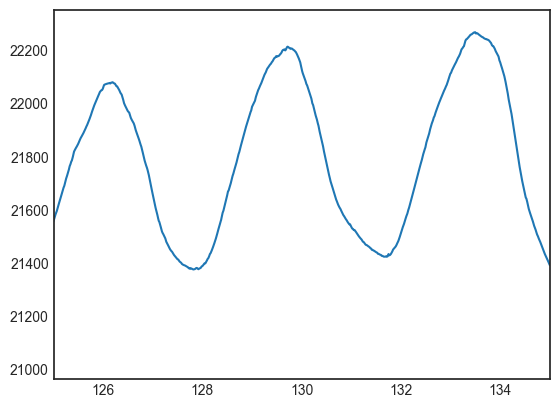

In [17]:

plt.plot(df['time'].values-df['time'].values.min(), sig)
plt.xlim(125,135)

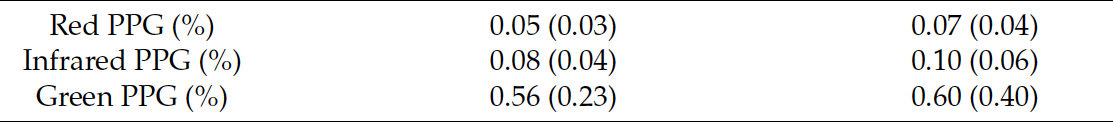

In [18]:
# IR: 0.13%
# Red: 0.66%
# Green: 0.25%

In [26]:
(80/32000)*100 # %

0.25

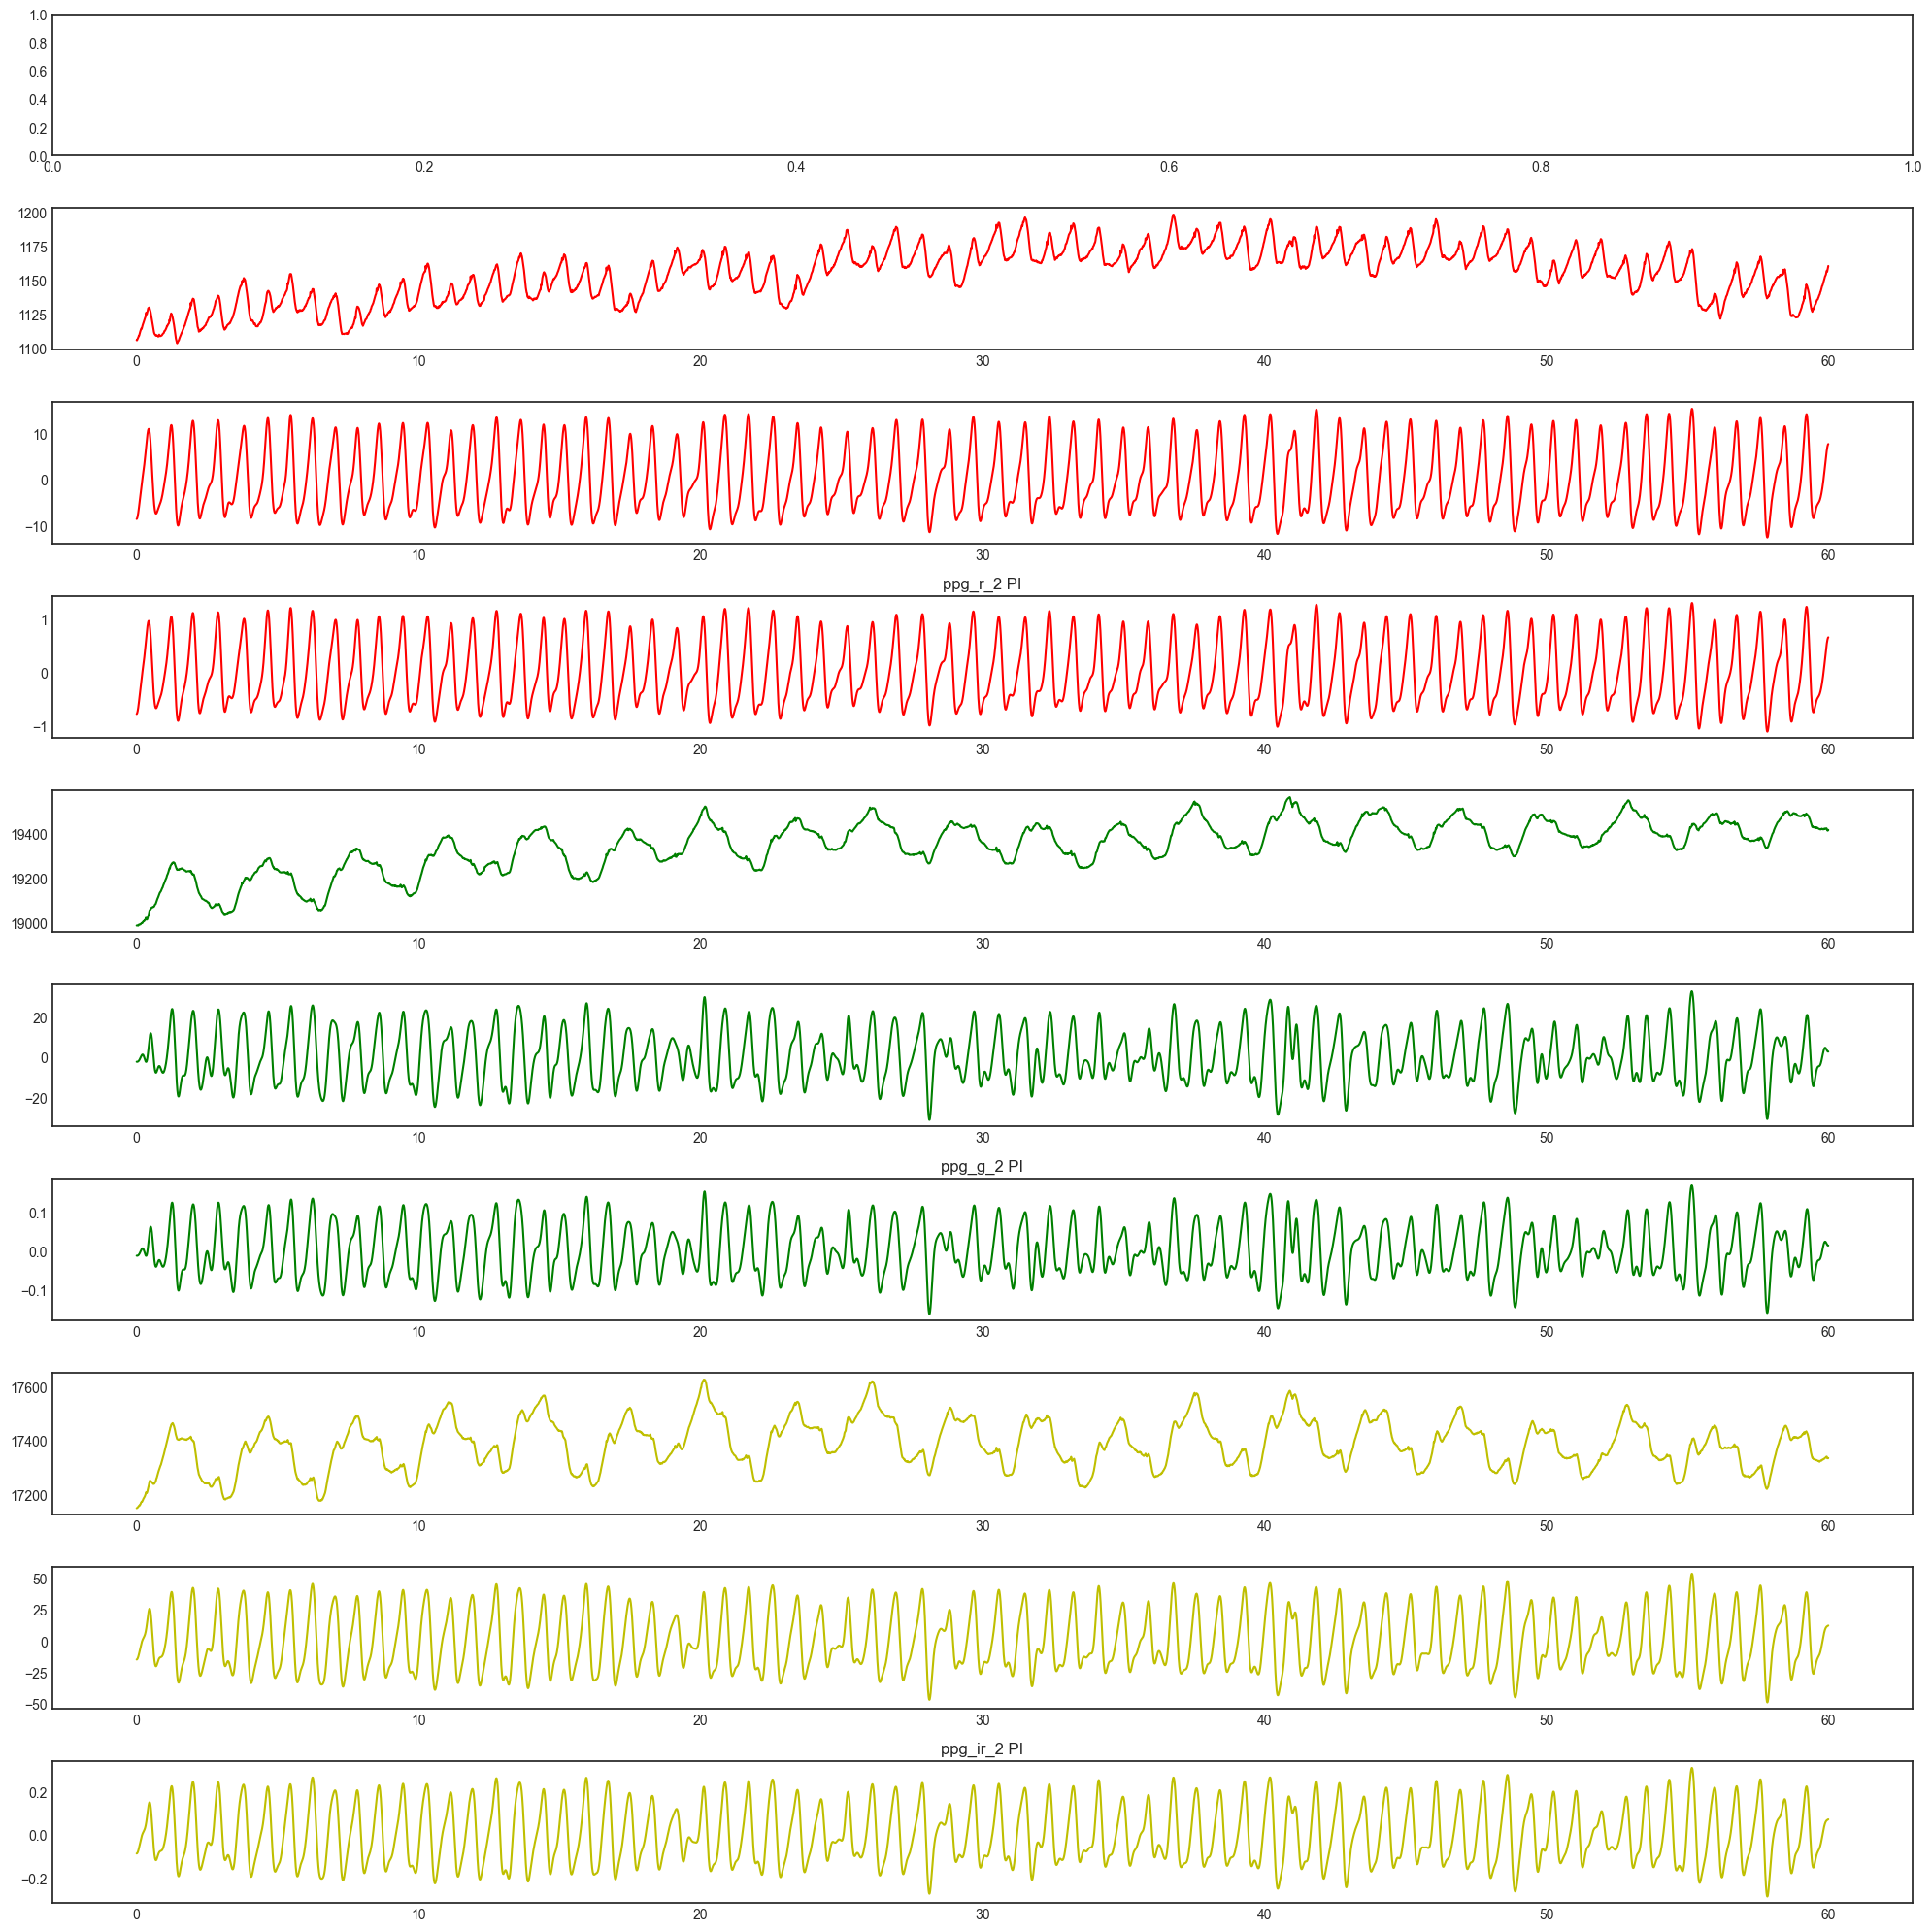

In [27]:
# df = df_subjects['105']

df_segment = df.reset_index(drop=True)[:int(60*FS_RESAMPLE)]
# df_segment = df[150000:190000].copy()

t_ppg = df_segment['time'].values
t_ppg = t_ppg - t_ppg.min()

get_padded_filt

fig, axes = plt.subplots(10, 1, figsize=(20,20), dpi=100)

# SpO2_biopac = df_segment['SpO2_biopac'].values

# axes[0].plot(t_ppg, SpO2_biopac)

pd_id = '2'

ppg_raw = df_segment['ppg_r_{}'.format(pd_id)].values
ppg_filtered = get_padded_filt(ppg_raw, filter_padded=1, lowcutoff=1, highcutoff=FILT_PPG[1], Fs=FS_RESAMPLE)
axes[1].plot(t_ppg, ppg_raw, color='r')
axes[2].plot(t_ppg, ppg_filtered, color='r')
axes[3].plot(t_ppg, ppg_filtered/ppg_raw*100, color='r')
axes[3].set_title('ppg_r_{} PI'.format(pd_id))

ppg_raw = df_segment['ppg_g_{}'.format(pd_id)].values
ppg_filtered = get_padded_filt(ppg_raw, filter_padded=1, lowcutoff=1, highcutoff=FILT_PPG[1], Fs=FS_RESAMPLE)
axes[4].plot(t_ppg, ppg_raw, color='g')
axes[5].plot(t_ppg, ppg_filtered, color='g')
axes[6].plot(t_ppg, ppg_filtered/ppg_raw*100, color='g')
axes[6].set_title('ppg_g_{} PI'.format(pd_id))

ppg_raw = df_segment['ppg_ir_{}'.format(pd_id)].values
ppg_filtered = get_padded_filt(ppg_raw, filter_padded=1, lowcutoff=1, highcutoff=FILT_PPG[1], Fs=FS_RESAMPLE)
axes[7].plot(t_ppg, ppg_raw, color='y')
axes[8].plot(t_ppg, ppg_filtered, color='y')
axes[9].plot(t_ppg, ppg_filtered/ppg_raw*100, color='y')
axes[9].set_title('ppg_ir_{} PI'.format(pd_id))

fig.tight_layout()

In [ ]:
plt.figure(figsize=(20,2))
plt.plot(df['time'].values-df['time'].values.min(), sig_filt)
plt.xlim(125,135)
plt.ylim(-80,80)

In [ ]:
plt.plot(df_copy['time'].values-df_copy['time'].values.min(),df_copy['ppg_r_1'].values)
# plt.xlim(100,120)

In [ ]:
df['time'].max()-df['time'].min(), df_copy['time'].max()-df_copy['time'].min()

In [ ]:
df_copy = get_filt_df(df, FS_RESAMPLE).copy()
df_copy = df_copy.reset_index(drop=True)[:int(60*FS_RESAMPLE)]

In [ ]:
plt.plot(ppg_ir_1)

In [ ]:
df_copy = get_filt_df(df, FS_RESAMPLE).copy()[:5000]

t_sig = df_copy['time'].values
t_sig = t_sig-t_sig.min()
ppg_ir_1 = df_copy['ppg_ir_1'].values
ppg_ir_2 = df_copy['ppg_ir_2'].values

ppg_g_1 = df_copy['ppg_g_1'].values
ppg_g_2 = df_copy['ppg_g_2'].values

ppg_r_1 = df_copy['ppg_r_1'].values
ppg_r_2 = df_copy['ppg_r_2'].values


# plt.plot(t_sig, ppg_ir_1)
# plt.plot(t_sig, ppg_ir_2)
plt.plot(t_sig, ppg_r_1)
plt.plot(t_sig, ppg_r_2)
# plt.plot(t_sig, ppg_g_1)
# plt.plot(t_sig, ppg_g_2)
# plt.xlim(0,30),

In [98]:
df_copy = get_filt_df(df, Fs).copy()
df_copy = df_copy.reset_index(drop=True)[:int(60*FS_RESAMPLE)]

In [99]:
HR_cosmed = df_copy['HR_cosmed'].mean()
RR_cosmed = df_copy['RR_cosmed'].mean()

In [100]:
# ppg = df_copy['ppg_r_2'].values
# t_sig = df_copy['time'].values
# t_sig = t_sig - t_sig.min()

# ppg_filtered = get_padded_filt(ppg, filter_padded=1, lowcutoff=(HR_cosmed-RR_cosmed)/60, highcutoff=(HR_cosmed+RR_cosmed)/60, Fs=FS_RESAMPLE)

# fig, axes = plt.subplots(2,1,figsize=(10,2),dpi=150)
# axes[0].plot(t_sig, ppg, 'black', alpha=0.5)
# axes[1].plot(t_sig, ppg_filtered)
# fig.tight_layout()

In [101]:
import numpy as np
from scipy.optimize import curve_fit

def kalman_denoising(data):
    
    # reference: https://jamwheeler.com/college-productivity/how-to-denoise-a-1-d-signal-with-a-kalman-filter-with-python/

    def oavar(data, rate, numpoints=30):

        x = np.cumsum(data)

        max_ratio = 1/9
        num_points = 30
        ms = np.unique(
            np.logspace(0, np.log10(len(x) * max_ratio), numpoints
           ).astype(int))        

        oavars = np.empty(len(ms))
        for i, m in enumerate(ms):
            oavars[i] = (
                (x[2*m:] - 2*x[m:-m] + x[:-2*m])**2
            ).mean() / (2*m**2)

        return ms / rate, oavars

    def ln_NKfit(ln_tau, ln_N, ln_K):
        tau = np.exp(ln_tau)
        N, K = np.exp([ln_N, ln_K])
        oadev = N**2 / tau + K**2 * (tau/3)
        return np.log(oadev)

    def get_NK(data, rate):
        taus, oavars = oavar(data, rate)

        ln_params, ln_varmatrix = (
            curve_fit(ln_NKfit, np.log(taus), np.log(oavars))
        )
        return np.exp(ln_params)    

    # Initialize state and uncertainty
    state = data[0]
    output = np.empty(len(data))

    rate = 1 # We can set this to 1, if we're calculating N, K internally
    # N and K will just be scaled relative to the sampling rate internally
    dt = 1/rate

    N, K = get_NK(data, rate)

    process_noise = K**2 * dt
    measurement_noise = N**2 / dt

    covariance = measurement_noise

    for index, measurement in enumerate(data):
        # 1. Predict state using system's model

        covariance += process_noise

        # Update
        kalman_gain = covariance / (covariance + measurement_noise)

        state += kalman_gain * (measurement - state)
        covariance = (1 - kalman_gain) * covariance

        output[index] = state

    return output

In [121]:
def CWTmax_denoising(sig, Fs):
    dt = 1/Fs
    # mother = wavelet.Morlet(6)
    mother = wavelet.Morlet(6)

    s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
    dj = 1 / 12  # Twelve sub-octaves per octaves
    J = 7 / dj  # Seven powers of two with dj sub-octaves
    # alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

    # The following routines perform the wavelet transform and inverse wavelet
    # transform using the parameters defined above. Since we have normalized our
    # input time-series, we multiply the inverse transform by the standard
    # deviation.
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(sig, dt, dj, s0, J,
                                                          mother)
#     iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
    i_row_max = np.argmax(np.abs(wave).sum(axis=1))
    # wave_denoised = np.zeros(wave.shape)
    mask = np.arange(wave.shape[0])!=i_row_max
    wave_denoised = wave.copy()
    wave_denoised[mask,:] = 0
    
    signal_denoised = wavelet.icwt(wave_denoised, scales, dt, dj, mother)
    
    # signal_denoised = np.abs(signal_denoised)
    return signal_denoised


In [104]:
df_copy = get_filt_df(df, FS_RESAMPLE).copy()[:5000]
ppg = df_copy['ppg_r_2'].values
t_sig = df_copy['time'].values


In [105]:


#     # plt.subplot(N,1,n+2)
# fig, axes = plt.subplots(imfs.shape[1]+1,1,figsize=(imfs.shape[1]*4,20),dpi=150)

    
# ax = axes[0]
# ax.plot(ppg, 'r')

# for n in range(imfs.shape[1]):
#     ax = axes[n+1]
#     imf = imfs[:,n]
#     ax.plot(imf, 'g')
#     ax.set_title("IMF "+str(n+1))
#     ax.set_xlabel("Time [s]")


In [107]:
# yf.shape

In [108]:
from PyEMD import EMD

def EMD_denoising(sig, Fs):
    # reference: S. Lu et al., “Can Photoplethysmography Variability Serve as an Alternative Approach to Obtain Heart Rate Variability Information?,” J Clin Monit Comput, vol. 22, no. 1, pp. 23–29, Jan. 2008, doi: 10.1007/s10877-007-9103-y.

    imfs = EMD().emd(sig)
    imfs = imfs.T
    # xf, yf = get_psd(imfs, FS_RESAMPLE)
    yf = [get_psd(imfs[:,n], Fs)[1] for n in range(imfs.shape[1])]
    yf = np.stack(yf).T

    xf, _ = get_psd(imfs[:,0], Fs)

    index_thre = np.where(xf>=0.5)[0][0]
    indices_dominant = np.argmax(yf,axis=0)

    mask = indices_dominant >= index_thre
    # # mask = indices_dominant[mask]
    imfs = imfs[:, mask]


    if imfs.shape[1]>=4:
        N_imfs = 4
    else:
        N_imfs = imfs.shape[1]

    xcorr_arr = np.zeros(imfs.shape[1])
    for i in range(imfs.shape[1]):
        imf = imfs[i]
        xcorr = np.max(np.abs(signal.correlate(ppg, imf)))
        xcorr_arr[i] = xcorr

    imfs = imfs[:, np.argsort(-xcorr_arr)[:N_imfs]]
    signal_reconstructed = imfs.sum(axis=1)

    return signal_reconstructed

In [109]:
# signal

In [122]:
ppg_filtered = get_padded_filt(ppg, filter_padded=1, lowcutoff=(HR_cosmed-RR_cosmed)/60, highcutoff=(HR_cosmed+RR_cosmed)/60, Fs=FS_RESAMPLE)
ppg_denoised = kalman_denoising(ppg)
ppg_cwt_denoised = CWTmax_denoising(ppg, FS_RESAMPLE)
ppg_EMD_denoised = EMD_denoising(ppg, FS_RESAMPLE)



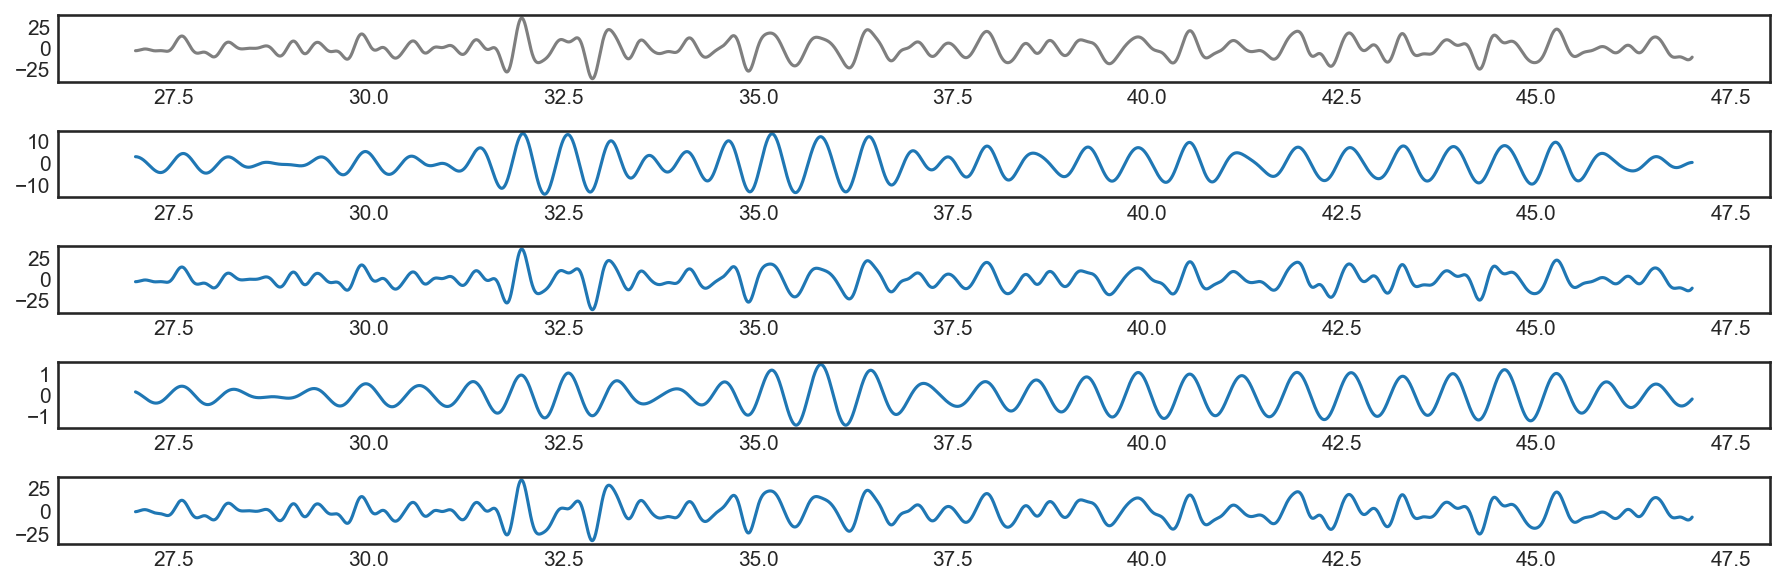

In [123]:
fig, axes = plt.subplots(5,1,figsize=(12,4),dpi=150)
axes[0].plot(t_sig, ppg, 'black', alpha=0.5)
axes[1].plot(t_sig, ppg_filtered)
axes[2].plot(t_sig, ppg_denoised)
axes[3].plot(t_sig, ppg_cwt_denoised)
axes[4].plot(t_sig, ppg_EMD_denoised)
fig.tight_layout()

In [ ]:
freq, yf = get_psd(ppg, FS_RESAMPLE)
mask = (freq>=label_range_dict['HR_DL'][0]/60) & (freq<=label_range_dict['HR_DL'][1]/60)
freq, yf = freq[mask], yf[mask]
plt.plot(freq, yf)

In [ ]:
freq, yf = get_psd(ppg_filtered, FS_RESAMPLE)
mask = (freq>=label_range_dict['HR_DL'][0]/60) & (freq<=label_range_dict['HR_DL'][1]/60)
freq, yf = freq[mask], yf[mask]
plt.plot(freq, yf)

In [ ]:
freq, yf = get_psd(ppg_denoised, FS_RESAMPLE)
mask = (freq>=label_range_dict['HR_DL'][0]/60) & (freq<=label_range_dict['HR_DL'][1]/60)
freq, yf = freq[mask], yf[mask]
plt.plot(freq, yf)

In [ ]:
freq, yf = get_psd(ppg_cwt_denoised, FS_RESAMPLE)
mask = (freq>=label_range_dict['HR_DL'][0]/60) & (freq<=label_range_dict['HR_DL'][1]/60)
freq, yf = freq[mask], yf[mask]
plt.plot(freq, yf)